In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
import matplotlib.font_manager as mfm
import matplotlib.patches as patches
import scipy as sp
import seaborn as sns
import nglview as nv
import MDAnalysis as mda
from MDAnalysis import Universe, Merge, transformations
import warnings
warnings.filterwarnings("ignore")

A Jupyter Widget

/home/ysubbotina/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
plt.style.use('seaborn-white')
sns.set(style="white", context="paper") #, palette="tab10")
sns.color_palette("Set1", n_colors=8, desat=.5)
rc('font', weight='bold')
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 12})

In [3]:
wd=os. getcwd() 

In [4]:
resFolder = wd+"/uam/"
pdbFolder = wd+"/pdb/"
pdbCGfolder = wd+"/pdbCG/"
npFolder  = wd+"/np/"
pngFolder  = wd+"/png/"

In [5]:
pdbIn=pdbFolder+"3v03.pdb"
npIn=npFolder+"Ag100_r-26.35_zp-0.031_pristine.np"
uamIn=resFolder+"3v03_26_0.uam"

In [6]:
protein=pdbIn.rsplit('/')[-1].rsplit(".")[0]
basename=npIn.rsplit('/')[-1].strip(".np")
nanopart=(basename.rsplit('_', 3)[0]).rsplit('_', 3)[0]
core=re.sub('[^a-zA-Z]+', '', nanopart)
radii=float(((basename.rsplit('_', 6)[1]).rsplit('_', 1)[0]).rsplit('-', 1)[1])
zeta=float(((basename.rsplit('_', 6)[2]).rsplit('_', 1)[0]).rsplit('-', 1)[1])

# Read in UAM, plot heatmap and find min conformation

Text(0, 0.5, '$\\theta$°')

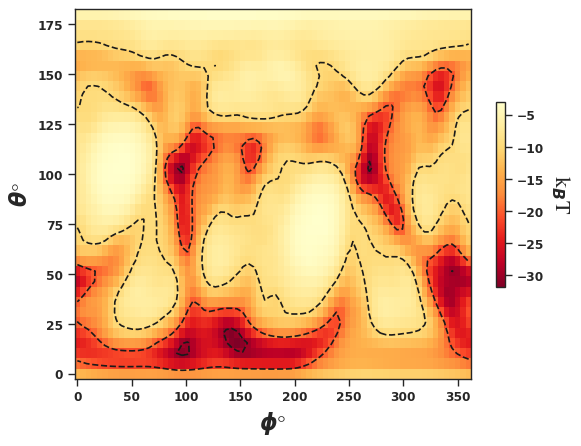

In [7]:
rawData         = np.genfromtxt(uamIn)
phiData         = rawData[:,0]
thetaData       = rawData[:,1]
energy          = rawData[:,2]
sdData          = rawData[:,3]
ssdData         = rawData[:,4]
sinTheta        = np.sin(thetaData * np.pi / 180.0)
boltzmanAverage = np.sum(energy * sinTheta * np.exp(-1.0 *  energy)) / np.sum(sinTheta * np.exp(-1.0 * energy))
simpleAverage   = np.mean(sinTheta * energy)
index           = np.argmin(energy)
delta           = phiData[1] - phiData[0]
rows            = int(180. / delta)
cols            = int(360. / delta)
image           = np.zeros((rows, cols))

#Select first lowest conformation
conf_id = 0
conf_phi = phiData[index]
conf_theta = thetaData[index]
conf_ssd = ssdData[index]
conf_ene = energy[index]

for phi, theta , energy , sd ,ssd, mfpt ,energy_kj, prot_surf_com_dist in rawData:
    row             = int(theta / delta)
    col             = int(phi / delta)
    image[row][col] = energy

lon = np.linspace(0, 360, cols)
lat = np.linspace(0, 180, rows)
Lon, Lat = np.meshgrid(lon,lat)
image = sp.ndimage.filters.gaussian_filter(image, sigma = [1.0, 1.0], mode = ['constant', 'wrap'])

# Plot the data
font_path = "/usr/share/fonts/truetype/freefont/FreeSerif.ttf"
fontsize  = 16
clabelpad = 20

font      = mfm.FontProperties(fname = font_path, size = fontsize)
xlabel    = r"$\phi$" + u"\u00B0"
ylabel    = r"$\theta$" + u"\u00B0"
clabel    = r"k${_B}$T";

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(Lon, Lat, image, cmap = plt.cm.YlOrRd_r)  #plt.cm.binary_r )
plt.contour(Lon, Lat, image, 2, colors='k')
cb = fig.colorbar(im, ax = ax, shrink = 0.5)
cb.set_label(clabel, rotation = 270, labelpad = clabelpad, fontproperties = font)
ax.set_xlabel(xlabel, fontproperties = font)
ax.set_ylabel(ylabel, fontproperties = font)


In [8]:
res_png = 900
figname_map_png=pngFolder+protein+"_"+basename +  "_heatmap.png"
figname_map_png
fig.savefig(figname_map_png, format='png', dpi=res_png,  transparent=True)

# Read in PDB for protein and transform accordinly to orientation data

In [9]:
u_prot = Universe(pdbIn)

In [11]:
#  Ian's code for rotation
def rotatePDB(coords,phi,theta):
    rxx = np.cos(theta)*np.cos(phi)
    rxy = -1 * np.cos(theta)*np.sin(phi)
    rxz = np.sin(theta)
    ryx = np.sin(phi)
    ryy = np.cos(phi)
    ryz = 0
    rzx = -1*np.sin(theta)*np.cos(phi)
    rzy = np.sin(theta)*np.sin(phi)
    rzz = np.cos(theta)
    finalCoords = np.zeros_like(coords)
    
    finalCoords[:,0] = coords[:,0] * rxx + coords[:,1] * rxy + coords[:,2]*rxz 
    finalCoords[:,1] = coords[:,0] * ryx + coords[:,1] * ryy + coords[:,2]*ryz 
    finalCoords[:,2] = coords[:,0] * rzx + coords[:,1] * rzy + coords[:,2]*rzz 
    return finalCoords

In [12]:
# UA rotation
minTheta = conf_theta  + 2.5
minPhi = conf_phi + 2.5
rawCoords = u_prot.atoms.positions
#rotate
rot_phi   = -1.0 * minPhi  * (np.pi / 180.0)
rot_theta = (180.0 - minTheta) * (np.pi / 180.0)
rotCoords =  rotatePDB(rawCoords ,rot_phi, rot_theta)
u_prot.atoms.positions=rotCoords

In [13]:
#  translation to origin
pHalf=(u_prot.atoms.center_of_mass()[2]-u_prot.atoms.positions.T[2].min())*0.1 # in nm
translate_to_origin = transformations.center_in_box(u_prot.atoms,center='mass', point=[0.0,0.0,0.0])
#npR+ssd in z dir in A
translate_by_ssd = transformations.center_in_box(u_prot.atoms,center='mass', point=[0.0,0.0,(pHalf+radii+conf_ssd)*10])
u_prot.trajectory.add_transformations(*[translate_to_origin,translate_by_ssd])

In [14]:
viewProt=nv.show_mdanalysis(u_prot)
viewProt._remote_call('setSize', target='Widget', args=['600px','600px'])
viewProt.add_representation(repr_type='cartoon', selection='protein', color='residueindex')
viewProt

A Jupyter Widget

# Combine with NP coordinate

In [15]:
elemDic={"Ag": "Ag",
         "Au": "Au"}
typeDic={"Ag": "Ag",
         "Au": "Ag"}
beadDicRGB={"Ag": [0.86, 0.86, 0.86],
            "Au": [1.0, 0.7, 0.0]}
beadDicHex={"Ag": "#DCDCDC",
            "Au": "#FFB300"}

In [16]:
rawNP         = np.genfromtxt(npIn,  delimiter=',' , skip_header=1, dtype=None)
NPcoordList=[]
NPresNameArray=[]
NPRad=[]
if rawNP.size > 1:
    i=1
    for line in rawNP:
        npX, npY, npZ, npR, _, _, _, _, ss, _, _, _ = line
        solid=(((str(ss)).rsplit( "/" )[2]).rsplit( "." ))[0]
        NPresNameArray.append([solid, solid, int(i)])
        NPcoordList.append([float(round(npX,3)*10), float(round(npY,3)*10), float(round(npZ,3)*10)])
        NPRad.append([int(i), solid, float(npR)])
        i=i+1
if rawNP.size ==1:
    NPcoordList.append([0.0, 0.0, 0.0])
    NPresNameArray.append([core,core, 1])
    NPRad.append([1,core, radii])
NPcoord=np.array(NPcoordList)
NPres=np.array(NPresNameArray)
NPRs=np.array(NPRad)    

In [17]:
nameLst=[]
resLst=[]
typeLst=[]
elemLst=[]
coorArr=[]
for i, line in enumerate(NPres):
    typeLst.append(typeDic[line[0]])
    elemLst.append(elemDic[line[0]])
    nameLst.append(line[0])
    resLst.append(line[1])
    coorArr.append(NPcoord[i])
n_residues = len(NPres)
n_atoms = len(NPres)
resindices = np.repeat(range(n_residues), 1)
assert len(resindices) == n_atoms
segindices = [0] * n_residues
u_nano = mda.Universe.empty(n_atoms,
                         n_residues=n_residues,
                         atom_resindex=resindices,
                         residue_segindex=segindices,
                         trajectory=True)
u_nano.add_TopologyAttr('name', nameLst)
u_nano.add_TopologyAttr('type', typeLst)
u_nano.add_TopologyAttr('elements', elemLst)
u_nano.add_TopologyAttr('resname', resLst)
u_nano.add_TopologyAttr('resid', list(range(1, n_residues+1)))
u_nano.add_TopologyAttr('segid', ["NP"])
u_nano.atoms.positions = coorArr

pdb_combo=pdbCGfolder+core+"_"+str(protein)+'_CG.pdb'
combo = Merge(u_prot.atoms, u_nano.atoms)
combo.atoms.write(pdb_combo)

# Visualize NP-protein complex

In [18]:
view=nv.show_mdanalysis(combo)
view._remote_call('setSize', target='Widget', args=['400px','600px'])
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='residueindex')
view.add_representation(repr_type='surface', surfaceType= 'av',  opaqueBack=False, selection='protein', opacity=0.05, color='indigo')
for bds in list(beadDicHex.keys()):
    view.add_representation(repr_type='spacefill', selection=bds,  opacity=0.6, color=beadDicHex[bds], radius=(radii*10))
central = view.shape
central.add_sphere([ 0.0, 0.0, 0.0 ], beadDicRGB[core], radii*0.75*10)
view.center()
view

A Jupyter Widget

In [20]:
view.parameters = dict(theme='light')
filename=core+"_"+str(protein)+'_CG.png'
view.download_image(filename=filename , factor=10, transparent=True)
filename

'Ag_3v03_CG.png'